In [1]:
import sys
import os
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import SimpleITK as sitk

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# test_or_val = "validation"
test_or_val = "test"

datafolder = f"../evaluation/contours_compare_{test_or_val}"

root, dirs, files = next(os.walk(f"{datafolder}"s))
for i, dir in enumerate(dirs):
    print(f"{i}: {dir}")



0: Dataset001_pca
1: Dataset005_pca
2: Dataset005_pca_simplified
3: Dataset006_pca_gg3gg4combined
4: Dataset007_pca_cribriform_only
5: Dataset008_pcaadc
6: Dataset008_pcaadc_simplified
7: Dataset009_pcaperf


In [12]:
set_number = 5

dataset = dirs[set_number]
dataset_path = f"{datafolder}/{dataset}"
print(dataset)
print(dataset_path)

Dataset008_pcaadc
./contours_compare_test/Dataset008_pcaadc


In [13]:
# try:
#     with open(f"{dataset_path}/summary.json") as f:
#         output_statistics = json.load(f)
# except:
#     print(f"{dataset} doesn't have a summary json. Aborting...")

### Defining a range of dice thresholds

helper functions to calculate metrics of the case of a single dice threshold \
metric used is F1-score 

$\frac{2tp}{2tp + fp + fn}$


In [14]:
def f1_score(dict_with_cm):
    TP, FP, TN, FN = dict_with_cm["TP"], dict_with_cm["FP"], dict_with_cm["TN"], dict_with_cm["FN"]

    score = 2 * TP / (2 * TP + FP + FN)
    return score

def sensitivity(dict_with_cm):
    TP, FP, TN, FN = dict_with_cm["TP"], dict_with_cm["FP"], dict_with_cm["TN"], dict_with_cm["FN"]

    score = TP / (TP + FN)
    return score

def specificity(dict_with_cm):
    TP, FP, TN, FN = dict_with_cm["TP"], dict_with_cm["FP"], dict_with_cm["TN"], dict_with_cm["FN"]
    print(FP, TN)
    score = TN / (TN + FP)
    return score

# Determine dice score of segmentation wrt ground truth
# regions to calculate dice score of are expected to be labeled with 1
def dice(gt, seg):
    label = 1
    twice_the_intersection = np.sum(np.where(seg == label, 1, 0)[gt == label]) * 2.0
    sum_of_volumes = np.sum(seg) + np.sum(gt)

    return twice_the_intersection / sum_of_volumes


In [15]:
dice_thresholds = np.arange(0.025, 0.91, 0.025)
print(dice_thresholds)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9  ]


In [16]:
gg3_f1_scores = []
gg4_f1_scores = []
cribriform_f1_scores = []
foreground_f1_scores = []

gg3_sensitivities = []
gg4_sensitivities = []
cribriform_sensitivities = []
foreground_sensitivities = []

path_to_gt = f"{dataset_path}/ground_truth"
path_to_mp = f"{dataset_path}/model_output"


# The evaluation of model output statistics
###############
# get_avg_dice_score = lambda stats_dicts: {label: stats_dicts[label]["tp_dice_scores_sum"]/stats_dicts[label]["TP"]  if stats_dicts[label]["TP"] != 0 else 0 for label in stats_dicts.keys()}

i = 0

# for dice_threshold in tqdm(dice_thresholds[0:1]):
for dice_threshold in tqdm(dice_thresholds):
    stats_dicts = {label:
                    {
                        "TP": 0,
                        "FP": 0,
                        "TN": 0,
                        "FN": 0,
                    }
                    for label in [1, 2, 3, 4]
                }

    for i, patient_filename in enumerate(os.listdir(path_to_gt)):        
        gt_array = sitk.GetArrayFromImage(sitk.ReadImage(f"{path_to_gt}/{patient_filename}"))
        mp_array = sitk.GetArrayFromImage(sitk.ReadImage(f"{path_to_mp}/{patient_filename}"))

        # For every label except background, consider only regions of that label and decide
        # on confusion metric and/or dice score for those regions
        for label in [1, 2, 3]:
            label_only_gt = np.where(gt_array == int(label), 1, 0)
            label_only_seg = np.where(mp_array == int(label), 1, 0)

            if np.all(label_only_gt == 0) and np.all(label_only_seg == 0):
                stats_dicts[label]["TN"] += 1
            elif np.all(label_only_gt == 0) and not np.all(label_only_seg == 0):
                stats_dicts[label]["FP"] += 1
            elif not np.all(label_only_gt == 0) and np.all(label_only_seg == 0):
                stats_dicts[label]["FN"] += 1
            else:
                dice_score = dice(label_only_gt, label_only_seg)

                if dice_score > dice_threshold:
                    stats_dicts[label]["TP"] += 1
                else:
                    stats_dicts[label]["FN"] += 1

        # Now do the same one more time, but without distinguishing between the different
        # patterns, so only for foreground vs background.
        simplified_gt_array = np.where(gt_array != 0, 1, 0)
        simplified_mp_array = np.where(mp_array != 0, 1, 0)

        if np.all(simplified_gt_array == 0) and np.all(simplified_mp_array == 0):
            stats_dicts[4]["TN"]
        elif np.all(simplified_gt_array == 0) and not np.all(simplified_mp_array == 0):
            stats_dicts[4]["FP"]
        elif not np.all(simplified_gt_array == 0) and np.all(simplified_mp_array == 0):
            stats_dicts[4]["FN"]
        else:
            dice_score = dice(simplified_gt_array, simplified_mp_array)

            if dice_score > dice_threshold:
                stats_dicts[4]["TP"] += 1
            else:
                stats_dicts[4]["FN"] += 1

    print(stats_dicts)
    # Saving this resulting f1_scores
    for label in stats_dicts.keys():
        print(f"{label} : {f1_score(stats_dicts[label])}")

        if label == 1:
            gg3_f1_scores.append(f1_score(stats_dicts[label]))
        elif label == 2:
            gg4_f1_scores.append(f1_score(stats_dicts[label]))
        elif label == 3:
            cribriform_f1_scores.append(f1_score(stats_dicts[label]))
        elif label == 4:
            foreground_f1_scores.append(f1_score(stats_dicts[label]))

        if label == 1:
            gg3_sensitivities.append(sensitivity(stats_dicts[label]))
        elif label == 2:
            gg4_sensitivities.append(sensitivity(stats_dicts[label]))
        elif label == 3:
            cribriform_sensitivities.append(sensitivity(stats_dicts[label]))
        elif label == 4:
            foreground_sensitivities.append(sensitivity(stats_dicts[label]))



  3%|▎         | 1/36 [00:09<05:37,  9.64s/it]

{1: {'TP': 39, 'FP': 7, 'TN': 0, 'FN': 7}, 2: {'TP': 30, 'FP': 8, 'TN': 2, 'FN': 13}, 3: {'TP': 2, 'FP': 14, 'TN': 25, 'FN': 12}, 4: {'TP': 51, 'FP': 0, 'TN': 0, 'FN': 2}}
1 : 0.8478260869565217
2 : 0.7407407407407407
3 : 0.13333333333333333
4 : 0.9807692307692307


  6%|▌         | 2/36 [00:18<05:20,  9.44s/it]

{1: {'TP': 38, 'FP': 7, 'TN': 0, 'FN': 8}, 2: {'TP': 27, 'FP': 8, 'TN': 2, 'FN': 16}, 3: {'TP': 2, 'FP': 14, 'TN': 25, 'FN': 12}, 4: {'TP': 51, 'FP': 0, 'TN': 0, 'FN': 2}}
1 : 0.8351648351648352
2 : 0.6923076923076923
3 : 0.13333333333333333
4 : 0.9807692307692307


  8%|▊         | 3/36 [00:28<05:08,  9.34s/it]

{1: {'TP': 36, 'FP': 7, 'TN': 0, 'FN': 10}, 2: {'TP': 26, 'FP': 8, 'TN': 2, 'FN': 17}, 3: {'TP': 1, 'FP': 14, 'TN': 25, 'FN': 13}, 4: {'TP': 50, 'FP': 0, 'TN': 0, 'FN': 3}}
1 : 0.8089887640449438
2 : 0.6753246753246753
3 : 0.06896551724137931
4 : 0.970873786407767


 11%|█         | 4/36 [00:37<04:58,  9.32s/it]

{1: {'TP': 32, 'FP': 7, 'TN': 0, 'FN': 14}, 2: {'TP': 24, 'FP': 8, 'TN': 2, 'FN': 19}, 3: {'TP': 1, 'FP': 14, 'TN': 25, 'FN': 13}, 4: {'TP': 50, 'FP': 0, 'TN': 0, 'FN': 3}}
1 : 0.7529411764705882
2 : 0.64
3 : 0.06896551724137931
4 : 0.970873786407767


 14%|█▍        | 5/36 [00:46<04:46,  9.23s/it]

{1: {'TP': 29, 'FP': 7, 'TN': 0, 'FN': 17}, 2: {'TP': 22, 'FP': 8, 'TN': 2, 'FN': 21}, 3: {'TP': 1, 'FP': 14, 'TN': 25, 'FN': 13}, 4: {'TP': 49, 'FP': 0, 'TN': 0, 'FN': 4}}
1 : 0.7073170731707317
2 : 0.6027397260273972
3 : 0.06896551724137931
4 : 0.9607843137254902


 17%|█▋        | 6/36 [00:55<04:37,  9.26s/it]

{1: {'TP': 26, 'FP': 7, 'TN': 0, 'FN': 20}, 2: {'TP': 21, 'FP': 8, 'TN': 2, 'FN': 22}, 3: {'TP': 1, 'FP': 14, 'TN': 25, 'FN': 13}, 4: {'TP': 48, 'FP': 0, 'TN': 0, 'FN': 5}}
1 : 0.6582278481012658
2 : 0.5833333333333334
3 : 0.06896551724137931
4 : 0.9504950495049505


 19%|█▉        | 7/36 [01:05<04:30,  9.32s/it]

{1: {'TP': 23, 'FP': 7, 'TN': 0, 'FN': 23}, 2: {'TP': 20, 'FP': 8, 'TN': 2, 'FN': 23}, 3: {'TP': 1, 'FP': 14, 'TN': 25, 'FN': 13}, 4: {'TP': 48, 'FP': 0, 'TN': 0, 'FN': 5}}
1 : 0.6052631578947368
2 : 0.5633802816901409
3 : 0.06896551724137931
4 : 0.9504950495049505


 22%|██▏       | 8/36 [01:14<04:22,  9.37s/it]

{1: {'TP': 23, 'FP': 7, 'TN': 0, 'FN': 23}, 2: {'TP': 19, 'FP': 8, 'TN': 2, 'FN': 24}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 48, 'FP': 0, 'TN': 0, 'FN': 5}}
1 : 0.6052631578947368
2 : 0.5428571428571428
3 : 0.0
4 : 0.9504950495049505


 25%|██▌       | 9/36 [01:23<04:11,  9.33s/it]

{1: {'TP': 23, 'FP': 7, 'TN': 0, 'FN': 23}, 2: {'TP': 18, 'FP': 8, 'TN': 2, 'FN': 25}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 47, 'FP': 0, 'TN': 0, 'FN': 6}}
1 : 0.6052631578947368
2 : 0.5217391304347826
3 : 0.0
4 : 0.94


 28%|██▊       | 10/36 [01:33<04:02,  9.32s/it]

{1: {'TP': 22, 'FP': 7, 'TN': 0, 'FN': 24}, 2: {'TP': 16, 'FP': 8, 'TN': 2, 'FN': 27}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 46, 'FP': 0, 'TN': 0, 'FN': 7}}
1 : 0.5866666666666667
2 : 0.47761194029850745
3 : 0.0
4 : 0.9292929292929293


 31%|███       | 11/36 [01:42<03:53,  9.35s/it]

{1: {'TP': 20, 'FP': 7, 'TN': 0, 'FN': 26}, 2: {'TP': 14, 'FP': 8, 'TN': 2, 'FN': 29}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 45, 'FP': 0, 'TN': 0, 'FN': 8}}
1 : 0.547945205479452
2 : 0.4307692307692308
3 : 0.0
4 : 0.9183673469387755


 33%|███▎      | 12/36 [01:51<03:43,  9.32s/it]

{1: {'TP': 20, 'FP': 7, 'TN': 0, 'FN': 26}, 2: {'TP': 13, 'FP': 8, 'TN': 2, 'FN': 30}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 43, 'FP': 0, 'TN': 0, 'FN': 10}}
1 : 0.547945205479452
2 : 0.40625
3 : 0.0
4 : 0.8958333333333334


 36%|███▌      | 13/36 [02:01<03:35,  9.37s/it]

{1: {'TP': 19, 'FP': 7, 'TN': 0, 'FN': 27}, 2: {'TP': 12, 'FP': 8, 'TN': 2, 'FN': 31}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 42, 'FP': 0, 'TN': 0, 'FN': 11}}
1 : 0.5277777777777778
2 : 0.38095238095238093
3 : 0.0
4 : 0.8842105263157894


 39%|███▉      | 14/36 [02:10<03:26,  9.37s/it]

{1: {'TP': 18, 'FP': 7, 'TN': 0, 'FN': 28}, 2: {'TP': 11, 'FP': 8, 'TN': 2, 'FN': 32}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 41, 'FP': 0, 'TN': 0, 'FN': 12}}
1 : 0.5070422535211268
2 : 0.3548387096774194
3 : 0.0
4 : 0.8723404255319149


 42%|████▏     | 15/36 [02:20<03:16,  9.35s/it]

{1: {'TP': 18, 'FP': 7, 'TN': 0, 'FN': 28}, 2: {'TP': 7, 'FP': 8, 'TN': 2, 'FN': 36}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 40, 'FP': 0, 'TN': 0, 'FN': 13}}
1 : 0.5070422535211268
2 : 0.2413793103448276
3 : 0.0
4 : 0.8602150537634409


 44%|████▍     | 16/36 [02:29<03:07,  9.35s/it]

{1: {'TP': 16, 'FP': 7, 'TN': 0, 'FN': 30}, 2: {'TP': 7, 'FP': 8, 'TN': 2, 'FN': 36}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 38, 'FP': 0, 'TN': 0, 'FN': 15}}
1 : 0.463768115942029
2 : 0.2413793103448276
3 : 0.0
4 : 0.8351648351648352


 47%|████▋     | 17/36 [02:38<02:57,  9.35s/it]

{1: {'TP': 13, 'FP': 7, 'TN': 0, 'FN': 33}, 2: {'TP': 6, 'FP': 8, 'TN': 2, 'FN': 37}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 37, 'FP': 0, 'TN': 0, 'FN': 16}}
1 : 0.3939393939393939
2 : 0.21052631578947367
3 : 0.0
4 : 0.8222222222222222


 50%|█████     | 18/36 [02:47<02:46,  9.27s/it]

{1: {'TP': 10, 'FP': 7, 'TN': 0, 'FN': 36}, 2: {'TP': 6, 'FP': 8, 'TN': 2, 'FN': 37}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 36, 'FP': 0, 'TN': 0, 'FN': 17}}
1 : 0.31746031746031744
2 : 0.21052631578947367
3 : 0.0
4 : 0.8089887640449438


 53%|█████▎    | 19/36 [02:57<02:37,  9.28s/it]

{1: {'TP': 8, 'FP': 7, 'TN': 0, 'FN': 38}, 2: {'TP': 5, 'FP': 8, 'TN': 2, 'FN': 38}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 35, 'FP': 0, 'TN': 0, 'FN': 18}}
1 : 0.26229508196721313
2 : 0.17857142857142858
3 : 0.0
4 : 0.7954545454545454


 56%|█████▌    | 20/36 [03:06<02:29,  9.31s/it]

{1: {'TP': 7, 'FP': 7, 'TN': 0, 'FN': 39}, 2: {'TP': 5, 'FP': 8, 'TN': 2, 'FN': 38}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 30, 'FP': 0, 'TN': 0, 'FN': 23}}
1 : 0.23333333333333334
2 : 0.17857142857142858
3 : 0.0
4 : 0.7228915662650602


 58%|█████▊    | 21/36 [03:15<02:19,  9.31s/it]

{1: {'TP': 7, 'FP': 7, 'TN': 0, 'FN': 39}, 2: {'TP': 4, 'FP': 8, 'TN': 2, 'FN': 39}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 28, 'FP': 0, 'TN': 0, 'FN': 25}}
1 : 0.23333333333333334
2 : 0.14545454545454545
3 : 0.0
4 : 0.691358024691358


 61%|██████    | 22/36 [03:25<02:10,  9.30s/it]

{1: {'TP': 7, 'FP': 7, 'TN': 0, 'FN': 39}, 2: {'TP': 3, 'FP': 8, 'TN': 2, 'FN': 40}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 27, 'FP': 0, 'TN': 0, 'FN': 26}}
1 : 0.23333333333333334
2 : 0.1111111111111111
3 : 0.0
4 : 0.675


 64%|██████▍   | 23/36 [03:34<02:00,  9.30s/it]

{1: {'TP': 6, 'FP': 7, 'TN': 0, 'FN': 40}, 2: {'TP': 3, 'FP': 8, 'TN': 2, 'FN': 40}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 27, 'FP': 0, 'TN': 0, 'FN': 26}}
1 : 0.2033898305084746
2 : 0.1111111111111111
3 : 0.0
4 : 0.675


 67%|██████▋   | 24/36 [03:43<01:51,  9.30s/it]

{1: {'TP': 5, 'FP': 7, 'TN': 0, 'FN': 41}, 2: {'TP': 3, 'FP': 8, 'TN': 2, 'FN': 40}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 22, 'FP': 0, 'TN': 0, 'FN': 31}}
1 : 0.1724137931034483
2 : 0.1111111111111111
3 : 0.0
4 : 0.5866666666666667


 69%|██████▉   | 25/36 [03:53<01:42,  9.29s/it]

{1: {'TP': 4, 'FP': 7, 'TN': 0, 'FN': 42}, 2: {'TP': 3, 'FP': 8, 'TN': 2, 'FN': 40}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 17, 'FP': 0, 'TN': 0, 'FN': 36}}
1 : 0.14035087719298245
2 : 0.1111111111111111
3 : 0.0
4 : 0.4857142857142857


 72%|███████▏  | 26/36 [04:02<01:33,  9.31s/it]

{1: {'TP': 4, 'FP': 7, 'TN': 0, 'FN': 42}, 2: {'TP': 2, 'FP': 8, 'TN': 2, 'FN': 41}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 15, 'FP': 0, 'TN': 0, 'FN': 38}}
1 : 0.14035087719298245
2 : 0.07547169811320754
3 : 0.0
4 : 0.4411764705882353


 75%|███████▌  | 27/36 [04:11<01:24,  9.39s/it]

{1: {'TP': 3, 'FP': 7, 'TN': 0, 'FN': 43}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 13, 'FP': 0, 'TN': 0, 'FN': 40}}
1 : 0.10714285714285714
2 : 0.0
3 : 0.0
4 : 0.3939393939393939


 78%|███████▊  | 28/36 [04:21<01:15,  9.46s/it]

{1: {'TP': 3, 'FP': 7, 'TN': 0, 'FN': 43}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 8, 'FP': 0, 'TN': 0, 'FN': 45}}
1 : 0.10714285714285714
2 : 0.0
3 : 0.0
4 : 0.26229508196721313


 81%|████████  | 29/36 [04:32<01:08,  9.79s/it]

{1: {'TP': 2, 'FP': 7, 'TN': 0, 'FN': 44}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 6, 'FP': 0, 'TN': 0, 'FN': 47}}
1 : 0.07272727272727272
2 : 0.0
3 : 0.0
4 : 0.2033898305084746


 83%|████████▎ | 30/36 [04:41<00:57,  9.64s/it]

{1: {'TP': 1, 'FP': 7, 'TN': 0, 'FN': 45}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 3, 'FP': 0, 'TN': 0, 'FN': 50}}
1 : 0.037037037037037035
2 : 0.0
3 : 0.0
4 : 0.10714285714285714


 86%|████████▌ | 31/36 [04:50<00:47,  9.50s/it]

{1: {'TP': 0, 'FP': 7, 'TN': 0, 'FN': 46}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 2, 'FP': 0, 'TN': 0, 'FN': 51}}
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.07272727272727272


 89%|████████▉ | 32/36 [05:00<00:37,  9.47s/it]

{1: {'TP': 0, 'FP': 7, 'TN': 0, 'FN': 46}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 53}}
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.0


 92%|█████████▏| 33/36 [05:09<00:28,  9.43s/it]

{1: {'TP': 0, 'FP': 7, 'TN': 0, 'FN': 46}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 53}}
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.0


 94%|█████████▍| 34/36 [05:18<00:18,  9.38s/it]

{1: {'TP': 0, 'FP': 7, 'TN': 0, 'FN': 46}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 53}}
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.0


 97%|█████████▋| 35/36 [05:27<00:09,  9.35s/it]

{1: {'TP': 0, 'FP': 7, 'TN': 0, 'FN': 46}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 53}}
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.0


100%|██████████| 36/36 [05:37<00:00,  9.36s/it]

{1: {'TP': 0, 'FP': 7, 'TN': 0, 'FN': 46}, 2: {'TP': 0, 'FP': 8, 'TN': 2, 'FN': 43}, 3: {'TP': 0, 'FP': 14, 'TN': 25, 'FN': 14}, 4: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 53}}
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.0


### Saving outputs to file

In [17]:
# dataset_sensitivities

In [20]:
dataset_f1scores = {
    "dice_thresholds": [round(threshold, 4) for threshold in dice_thresholds],
    "GG3": gg3_f1_scores,
    "GG4": gg4_f1_scores,
    "Cribriform": cribriform_f1_scores,
    "Foreground": foreground_f1_scores
}

with open(f"{dataset_path}/{dataset}_f1scores.json", 'w', encoding = 'utf-8') as f:
    json.dump(dataset_f1scores, f, ensure_ascii = False, indent = 4)

In [21]:
dataset_sensitivities = {
    "dice_thresholds": [round(threshold, 4) for threshold in dice_thresholds],
    "GG3": gg3_sensitivities,
    "GG4": gg4_sensitivities,
    "Cribriform": cribriform_sensitivities,
    "Foreground": foreground_sensitivities
}

with open(f"{dataset_path}/{dataset}_sensitivities.json", 'w', encoding = 'utf-8') as f:
    json.dump(dataset_sensitivities, f, ensure_ascii = False, indent = 4)

In [27]:
print(datafolder)
# Save outputs in json files to save time

all_modalities_data_path = f"{datafolder}/Dataset005_pca"
t2adc_data_path = f"{datafolder}/Dataset008_pcaadc"

with open(f"{all_modalities_data_path}/Dataset005_pca_f1scores.json", "r") as f:
    allmodalities_f1scores = json.load(f)

with open(f"{all_modalities_data_path}/Dataset005_pca_sensitivities.json", "r") as f:
    allmodalities_sensitivities = json.load(f)

with open(f"{t2adc_data_path}/Dataset008_pcaadc_f1scores.json", "r") as f:
    t2adc_f1scores = json.load(f)

with open(f"{t2adc_data_path}/Dataset008_pcaadc_sensitivities.json", "r") as f:
    t2adc_sensitivities = json.load(f)

./contours_compare_test


In [60]:
usual_threshold = allmodalities_f1scores["dice_thresholds"].index(0.1)

print(allmodalities_f1scores["GG3"][usual_threshold])
print(allmodalities_f1scores["GG4"][usual_threshold])
print(allmodalities_f1scores["Cribriform"][usual_threshold])
print(allmodalities_f1scores["Foreground"][usual_threshold])
print()

print(allmodalities_sensitivities["GG3"][usual_threshold])
print(allmodalities_sensitivities["GG4"][usual_threshold])
print(allmodalities_sensitivities["Cribriform"][usual_threshold])
print(allmodalities_sensitivities["Foreground"][usual_threshold])
print()

print(t2adc_f1scores["GG3"][usual_threshold])
print(t2adc_f1scores["GG4"][usual_threshold])
print(t2adc_f1scores["Cribriform"][usual_threshold])
print(t2adc_f1scores["Foreground"][usual_threshold])
print()

print(t2adc_sensitivities["GG3"][usual_threshold])
print(t2adc_sensitivities["GG4"][usual_threshold])
print(t2adc_sensitivities["Cribriform"][usual_threshold])
print(t2adc_sensitivities["Foreground"][usual_threshold])
print()

allmodalities_sensitivities
t2adc_f1scores
t2adc_sensitivities

0.8351648351648352
0.6133333333333333
0.1
0.9807692307692307

0.8260869565217391
0.5348837209302325
0.07142857142857142
0.9622641509433962

0.7529411764705882
0.64
0.06896551724137931
0.970873786407767

0.6956521739130435
0.5581395348837209
0.07142857142857142
0.9433962264150944



{'dice_thresholds': [0.025,
  0.05,
  0.075,
  0.1,
  0.125,
  0.15,
  0.175,
  0.2,
  0.225,
  0.25,
  0.275,
  0.3,
  0.325,
  0.35,
  0.375,
  0.4,
  0.425,
  0.45,
  0.475,
  0.5,
  0.525,
  0.55,
  0.575,
  0.6,
  0.625,
  0.65,
  0.675,
  0.7,
  0.725,
  0.75,
  0.775,
  0.8,
  0.825,
  0.85,
  0.875,
  0.9],
 'GG3': [0.8478260869565217,
  0.8260869565217391,
  0.782608695652174,
  0.6956521739130435,
  0.6304347826086957,
  0.5652173913043478,
  0.5,
  0.5,
  0.5,
  0.4782608695652174,
  0.43478260869565216,
  0.43478260869565216,
  0.41304347826086957,
  0.391304347826087,
  0.391304347826087,
  0.34782608695652173,
  0.2826086956521739,
  0.21739130434782608,
  0.17391304347826086,
  0.15217391304347827,
  0.15217391304347827,
  0.15217391304347827,
  0.13043478260869565,
  0.10869565217391304,
  0.08695652173913043,
  0.08695652173913043,
  0.06521739130434782,
  0.06521739130434782,
  0.043478260869565216,
  0.021739130434782608,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '

In [28]:
sns.set_style('darkgrid')

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

Text(0, 0.5, 'Sensitivity')

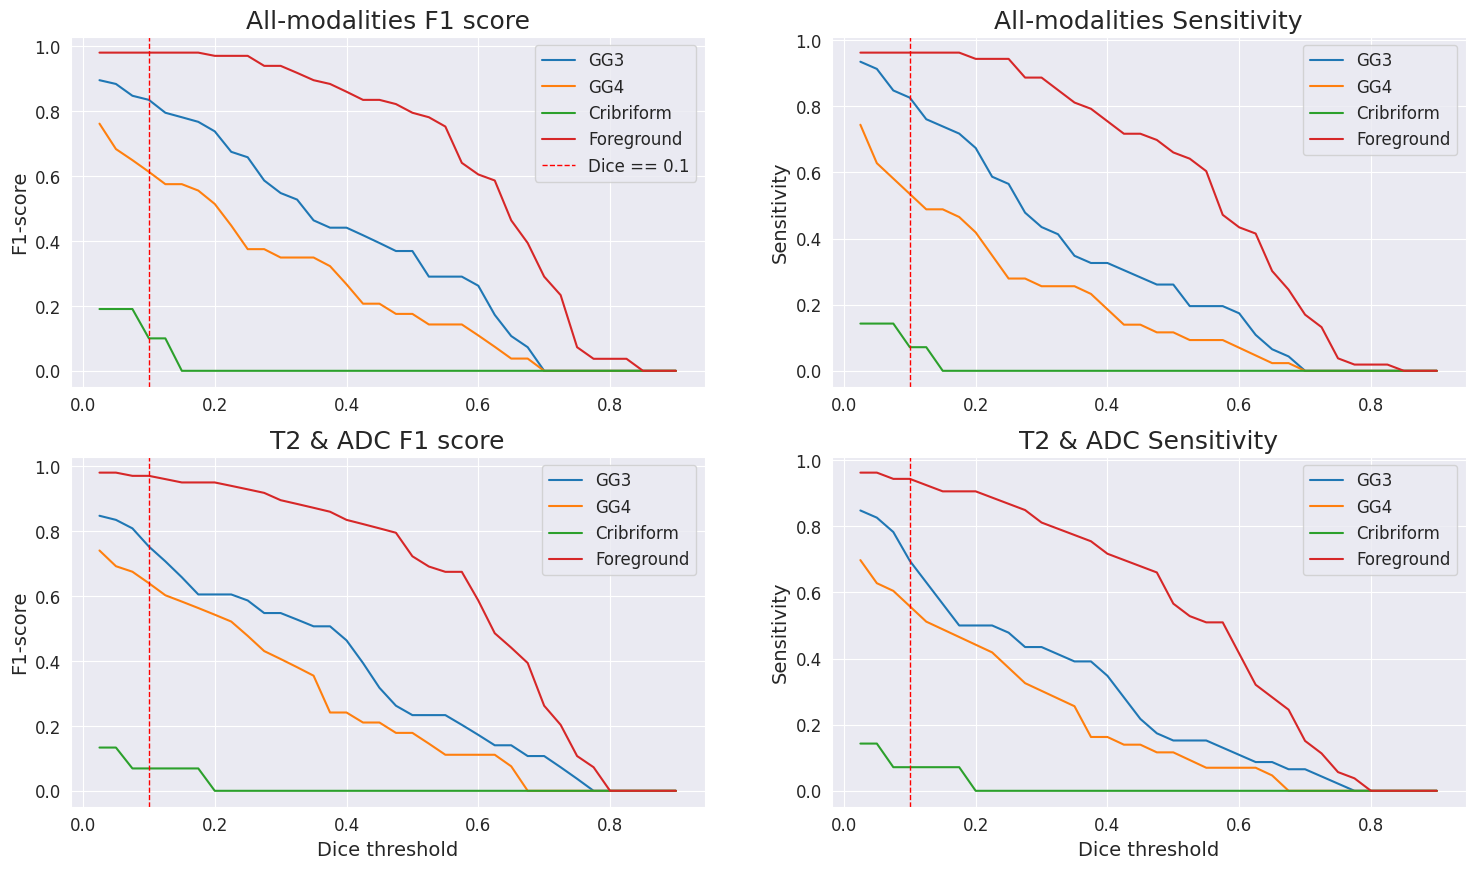

In [55]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

fig, axes = plt.subplots(2, 2, figsize = (18, 10))

sns.lineplot(x = dice_thresholds, y = allmodalities_f1scores["GG3"], ax = axes[0][0], label = "GG3")
sns.lineplot(x = dice_thresholds, y = allmodalities_f1scores["GG4"], ax = axes[0][0], label = "GG4")
sns.lineplot(x = dice_thresholds, y = allmodalities_f1scores["Cribriform"], ax = axes[0][0], label = "Cribriform")
sns.lineplot(x = dice_thresholds, y = allmodalities_f1scores["Foreground"], ax = axes[0][0], label = "Foreground")
axes[0][0].axvline(0.1, color = "red", linestyle = "dashed", linewidth = 1, label = "Dice == 0.1")

sns.lineplot(x = dice_thresholds, y = allmodalities_sensitivities["GG3"], ax = axes[0][1], label = "GG3")
sns.lineplot(x = dice_thresholds, y = allmodalities_sensitivities["GG4"], ax = axes[0][1], label = "GG4")
sns.lineplot(x = dice_thresholds, y = allmodalities_sensitivities["Cribriform"], ax = axes[0][1], label = "Cribriform")
sns.lineplot(x = dice_thresholds, y = allmodalities_sensitivities["Foreground"], ax = axes[0][1], label = "Foreground")
axes[0][1].axvline(0.1, color = "red", linestyle = "dashed", linewidth = 1, label = "Dice == 0.1")

# T2 & ADC model
sns.lineplot(x = dice_thresholds, y = t2adc_f1scores["GG3"], ax = axes[1][0], label = "GG3")
sns.lineplot(x = dice_thresholds, y = t2adc_f1scores["GG4"], ax = axes[1][0], label = "GG4")
sns.lineplot(x = dice_thresholds, y = t2adc_f1scores["Cribriform"], ax = axes[1][0], label = "Cribriform")
sns.lineplot(x = dice_thresholds, y = t2adc_f1scores["Foreground"], ax = axes[1][0], label = "Foreground")
axes[1][0].axvline(0.1, color = "red", linestyle = "dashed", linewidth = 1, label = "Dice == 0.1")

sns.lineplot(x = dice_thresholds, y = t2adc_sensitivities["GG3"], ax = axes[1][1], label = "GG3")
sns.lineplot(x = dice_thresholds, y = t2adc_sensitivities["GG4"], ax = axes[1][1], label = "GG4")
sns.lineplot(x = dice_thresholds, y = t2adc_sensitivities["Cribriform"], ax = axes[1][1], label = "Cribriform")
sns.lineplot(x = dice_thresholds, y = t2adc_sensitivities["Foreground"], ax = axes[1][1], label = "Foreground")
axes[1][1].axvline(0.1, color = "red", linestyle = "dashed", linewidth = 1, label = "Dice == 0.1")

axes[0][0].set_title("All-modalities F1 score")
axes[0][1].set_title("All-modalities Sensitivity")
axes[1][0].set_title("T2 & ADC F1 score")
axes[1][1].set_title("T2 & ADC Sensitivity")

axes[0][0].legend()
# axes[0][0].set_xlabel("Dice threshold")
# axes[0][1].set_xlabel("Dice threshold")
axes[1][0].set_xlabel("Dice threshold")
axes[1][1].set_xlabel("Dice threshold")
axes[0][0].set_ylabel("F1-score")
axes[1][0].set_ylabel("F1-score")
axes[0][1].set_ylabel("Sensitivity")
axes[1][1].set_ylabel("Sensitivity")


# plt.suptitle(f"Metrics for region detection\n")


In [ ]:
# dice_thresholds.index(0.1)

index_of_usual_threshold = np.where(dice_thresholds == 0.1)[0][0]

print(gg3_f1_scores[index_of_usual_threshold])
print(gg4_f1_scores[index_of_usual_threshold])
print(cribriform_f1_scores[index_of_usual_threshold])

In [ ]:
fig, axis = plt.subplots(figsize = (8, 6))

sns.lineplot(x = dice_thresholds, y = gg3_sensitivity_scores, ax = axis, label = "GG3 sensitivity")
sns.lineplot(x = dice_thresholds, y = gg4_sensitivity_scores, ax = axis, label = "GG4 sensitivity")
sns.lineplot(x = dice_thresholds, y = cribriform_sensitivity_scores, ax = axis, label = "Cribriform sensitivity")

sns.lineplot(x = dice_thresholds, y = gg3_specificity_scores, ax = axis, label = "GG3 specificity")
sns.lineplot(x = dice_thresholds, y = gg4_specificity_scores, ax = axis, label = "GG4 specificity")
sns.lineplot(x = dice_thresholds, y = cribriform_specificity_scores, ax = axis, label = "Cribriform specificity")

plt.legend()
plt.xlabel("Dice threshold")
plt.ylabel("Value of metric")
plt.title(f"All-modalities dataset sensitivity and specificity for different TP-thresholds of Volumetric Dice score")

In [ ]:
# print(len(os.listdir(path_to_simplified_gt)))
# print(len(foreground_background_dices))
# print(len(data))
# data.loc[16]
# # for dice in foreground_background_dices:
# #     print(dice)

In [ ]:
data["fgbg_dices"] = foreground_background_dices[:42]
data[['filename','structure', 'volumetric_dice', 'fgbg_dices']]


In [ ]:
path_to_imgs = f"../../exploratory-data-analysis"
all_modalities_fig = plt.imread(f"{path_to_imgs}/region_detection_f1_scores_allmodalities.png")
t2adc_fig = plt.imread(f"{path_to_imgs}/region_detection_f1_scores_t2_adc.png")

fig, axs = plt.subplots(1, 2, figsize = (16, 10))
plt.xticks(None)
axs[0].imshow(all_modalities_fig)
axs[1].imshow(t2adc_fig)